## This notebook is to demonstrate the training of CNN models for Lung CT Scan classification.
### Imports are added here :

In [1]:
import os
import torch
from torchvision.io import read_image
from torch.utils.data import Dataset,random_split,DataLoader
from torchvision.transforms import ToPILImage
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision import models
from torch import optim
from torch.nn import CrossEntropyLoss
from torchvision import datasets
import tqdm as notebook_tqdm
#import pretrainedmodels
from sklearn.metrics import precision_score, recall_score, f1_score
# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/krishnatejaswis/Files/VSCode/LungScan/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Next we declare the constants needed for training the model.

In [2]:
BATCHSIZE = 16
EPOCHS = 10

In [3]:
print(f'Device being used is {device}')
print(f'Batch size is {BATCHSIZE}')

Device being used is cuda
Batch size is 16


In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.classes = os.listdir(img_dir)
        print(self.classes)
        self.images = []
        self.class_counts = {class_: 0 for class_ in self.classes}  # Initialize class counts

        for class_ in self.classes:
            for dirpath, dirnames, filenames in os.walk(os.path.join(img_dir, class_)):
                for filename in filenames:
                    self.images.append((os.path.join(dirpath, filename), class_))
                    self.class_counts[class_] += 1  # Increment class count

        print("Class counts:", self.class_counts)  # Print class counts

    def __len__(self):
        return len(self.images)
    
    
    
    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        img = read_image(img_path).float()  # Convert the images to float
        img = img.repeat(3, 1, 1)  # Convert the images to 3 channels
        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            label = self.target_transform(label)
            print(label)
        # Convert label to tensor
        label = torch.tensor(self.classes.index(label))  # Convert class name to class index
        return img, label


    

    def __getitemImg__(self, idx):
        img_path, label = self.images[idx]
        img = read_image(img_path).float()  # Convert the images to float
        img = ToPILImage()(img)  # Convert the tensor to a PIL Image
        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            label = self.target_transform(label)
        return img, label

    
    def show_first_images(self, num_images=5):
        fig = plt.figure(figsize=(10, num_images * len(self.classes)))
        for i, class_ in enumerate(self.classes):
            class_images = [img for img, label in self.images if label == class_]
            for j in range(num_images):
                img = read_image(class_images[j]).float()
                img = ToPILImage()(img)
                if self.transform:
                    img = self.transform(img)
                ax = fig.add_subplot(len(self.classes), num_images, i * num_images + j + 1)
                ax.imshow(img, cmap='gray')
                ax.set_title(class_)
                ax.axis('off')
        plt.show()


In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to 224 x 224
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize the images
])

In [6]:
dataset = CustomImageDataset(img_dir='./DataSetkaggle')

['Covid19', 'Pneumonia', 'Negetive']
Class counts: {'Covid19': 2035, 'Pneumonia': 3390, 'Negetive': 2119}


In [7]:
dataset.__len__()

7544

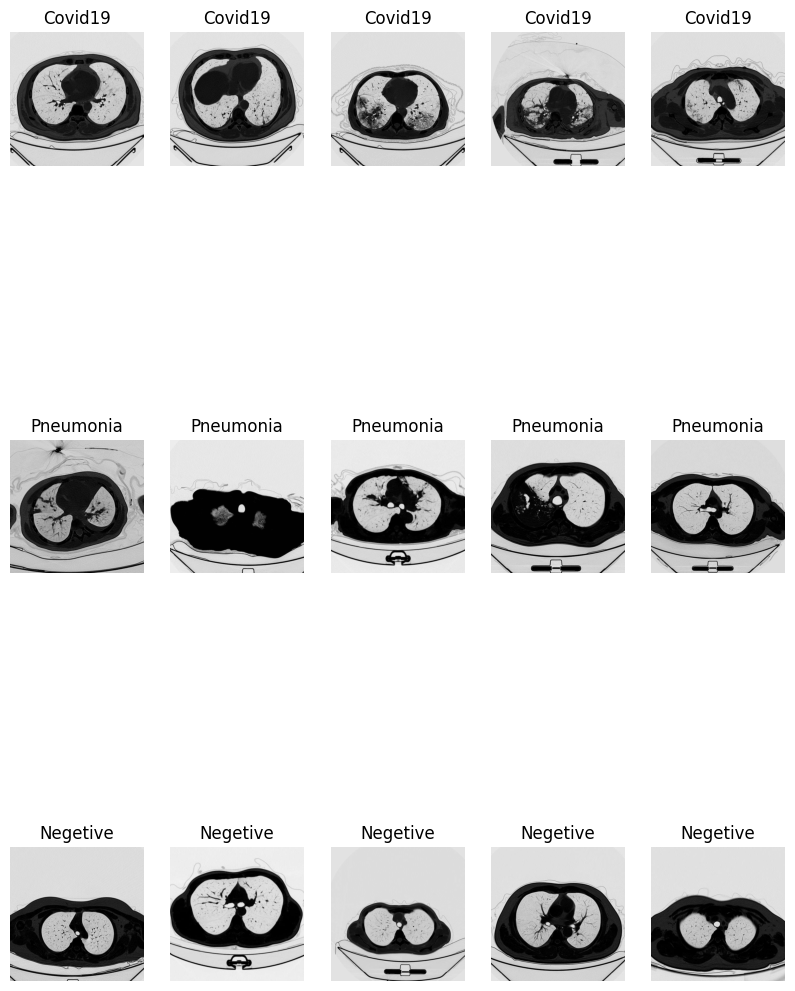

In [8]:
dataset.show_first_images()

In [9]:
dataset = CustomImageDataset(img_dir='./DataSetkaggle', transform=transform)

['Covid19', 'Pneumonia', 'Negetive']
Class counts: {'Covid19': 2035, 'Pneumonia': 3390, 'Negetive': 2119}


In [10]:
def get_model(name):
    if name.lower() == 'resnet50':
        model = models.resnet50(weights=True)
        num_ftrs = model.fc.in_features
        model.fc = torch.nn.Linear(num_ftrs, 3)
    elif name.lower() == 'vgg19':
        model = models.vgg19_bn(weights=True)
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = torch.nn.Linear(num_ftrs, 3)
    elif name.lower() == 'densenet121':
        model = models.densenet121(weights=True)
        num_ftrs = model.classifier.in_features
        model.classifier = torch.nn.Linear(num_ftrs, 3)
    elif name.lower() == 'googlenet':
        model = models.googlenet(weights = True)
        num_ftrs = model.fc.in_features
        model.fc = torch.nn.Linear(num_ftrs, 3)
    elif name.lower() == 'mobilenet':
        model = models.mobilenet_v3_large(weights=True)
        num_ftrs = model.classifier[3].in_features
        model.classifier[3] = torch.nn.Linear(num_ftrs,3) 
    else:
        raise ValueError('Invalid model name')
    return model

In [11]:
#vgg19_model = get_model('vgg19')
#resnet_model = get_model('resnet50')
#densenet121_model = get_model('densenet121')
#googlenet_model = get_model('googlenet')
mobilenet_model = get_model('mobilenet')

/home/krishnatejaswis/Files/VSCode/LungScan/env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
#vgg19_model = vgg19_model.to(device)
#resnet_model = resnet_model.to(device)
#densenet121_model = densenet121_model.to(device)
#googlenet_model = googlenet_model.to(device)
mobilenet_model = mobilenet_model.to(device)



In [13]:
# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
print("Training Size : ",train_size," Validation Size : ",val_size)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

Training Size :  6035  Validation Size :  1509


In [14]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCHSIZE)

In [15]:
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns

def train_model(model, dataloader, optimizer, criterion, num_epochs=25, patience=5):
    best_loss = float('inf')
    no_improvement_count = 0
    model_name = type(model).__name__  # Get the name of the model
    os.makedirs(model_name, exist_ok=True)  # Create a directory named after the model

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0
        running_preds = []
        running_labels = []
        losses = []
        accuracies = []

        # Iterate over data
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Print iteration results
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            running_preds.extend(preds.cpu().numpy())
            running_labels.extend(labels.data.cpu().numpy())
            losses.append(loss.item())
            accuracies.append((torch.sum(preds == labels.data).double() / inputs.size(0)).item())
            if i % 10 == 0:  # Print every 10 batches
                print(f'Batch {i} Loss: {loss.item():.4f} Acc: {torch.sum(preds == labels.data).double() / inputs.size(0):.4f}')

        # Plot loss and accuracy vs batch
        plt.figure(figsize=(12, 4))
        plt.subplot(121)
        plt.plot(losses)
        plt.title('Loss vs Batch')
        plt.subplot(122)
        plt.plot(accuracies)
        plt.title('Accuracy vs Batch')
        plt.savefig(f'{model_name}/epoch_{epoch+1}_loss_accuracy.png')
        plt.close()

        # Print epoch results
        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)
        epoch_precision = precision_score(running_labels, running_preds, average='macro')
        epoch_recall = recall_score(running_labels, running_preds, average='macro')
        epoch_f1 = f1_score(running_labels, running_preds, average='macro')
        print(f'Epoch Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        print(f'Epoch Precision: {epoch_precision:.4f} Recall: {epoch_recall:.4f} F1-score: {epoch_f1:.4f}\n')

        # Plot confusion matrix
        cm = confusion_matrix(running_labels, running_preds)
        plt.figure(figsize=(10, 10))
        sns.heatmap(cm, annot=True, fmt='d')
        plt.title('Confusion Matrix')
        plt.savefig(f'{model_name}/epoch_{epoch+1}_confusion_matrix.png')
        plt.close()

        # Check for early stopping
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            no_improvement_count = 0
        else:
            no_improvement_count += 1
            if no_improvement_count >= patience:
                print(f'Early stopping after {epoch+1} epochs without improvement.')
                return model

    return model

In [16]:
# Define the loss function and the optimizer
criterion = CrossEntropyLoss()

In [17]:
#optimizer_resnet = optim.SGD(resnet_model.parameters(), lr=0.0001, momentum=0.9)
#optimizer_vgg19 = optim.SGD(vgg19_model.parameters(), lr=0.0001, momentum=0.9)
#optimizer_densenet121 = optim.SGD(densenet121_model.parameters(), lr=0.0001, momentum=0.9)
#optimizer_googlenet = optim.SGD(googlenet_model.parameters(),lr=0.0001,momentum=0.9)
optimizer_mobilenet = optim.SGD(mobilenet_model.parameters(),lr=0.0001,momentum=0.9)

In [18]:
# Train the models
#resnet_model = train_model(resnet_model, train_dataloader, optimizer_resnet, criterion,num_epochs=EPOCHS)
#vgg19_model = train_model(vgg19_model, train_dataloader, optimizer_vgg19, criterion,num_epochs=EPOCHS)
#densenet121_model = train_model(densenet121_model, train_dataloader, optimizer_densenet121, criterion, num_epochs=EPOCHS)
#googlenet_model = train_model(googlenet_model, train_dataloader, optimizer_googlenet, criterion, num_epochs=EPOCHS)
mobilenet_model = train_model(mobilenet_model,train_dataloader,optimizer_mobilenet,criterion,num_epochs=EPOCHS)

Epoch 1/10
----------
Batch 0 Loss: 1.1305 Acc: 0.2500
Batch 10 Loss: 1.1572 Acc: 0.2500
Batch 20 Loss: 1.0093 Acc: 0.5625
Batch 30 Loss: 1.0174 Acc: 0.4375
Batch 40 Loss: 1.0498 Acc: 0.5000
Batch 50 Loss: 0.9886 Acc: 0.7500
Batch 60 Loss: 0.9884 Acc: 0.6250
Batch 70 Loss: 1.0097 Acc: 0.5625
Batch 80 Loss: 1.0427 Acc: 0.5000
Batch 90 Loss: 0.9100 Acc: 0.6250
Batch 100 Loss: 0.9518 Acc: 0.6875
Batch 110 Loss: 0.9199 Acc: 0.5000
Batch 120 Loss: 0.8570 Acc: 0.7500
Batch 130 Loss: 0.8481 Acc: 0.7500
Batch 140 Loss: 0.8677 Acc: 0.6875
Batch 150 Loss: 0.8361 Acc: 0.7500
Batch 160 Loss: 0.8512 Acc: 0.6875
Batch 170 Loss: 0.8335 Acc: 0.7500
Batch 180 Loss: 0.7113 Acc: 0.8750
Batch 190 Loss: 0.6776 Acc: 0.8125
Batch 200 Loss: 0.6369 Acc: 0.9375
Batch 210 Loss: 0.6517 Acc: 0.9375
Batch 220 Loss: 0.6872 Acc: 0.8125
Batch 230 Loss: 0.7719 Acc: 0.6875
Batch 240 Loss: 0.8068 Acc: 0.5625
Batch 250 Loss: 0.7118 Acc: 0.6875
Batch 260 Loss: 0.7509 Acc: 0.5625
Batch 270 Loss: 0.8404 Acc: 0.6250
Batch 280

In [19]:
torch.save(mobilenet_model,'./Solo Models/mobilenet_model.pth')
